<a href="https://colab.research.google.com/github/ASRC-com/ML-project/blob/main/Interpretable_Decision_tree_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install Required libraries

In [1]:
!pip install shap
!pip install lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=0ea2cfd30e4ad6c8186e43ddf089790f030a3fba1b2b1bbbe8bd10716721a82c
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


Import required libraries

In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
import shap
import lime
import lime.lime_tabular

Load the dataset

In [64]:
df = pd.read_csv('/content/drug200.csv')

Preprocessing: Encode categorical variables

In [65]:
le_sex = LabelEncoder()
le_BP = LabelEncoder()
le_Chol = LabelEncoder()
le_Drug = LabelEncoder()

df['Sex'] = le_sex.fit_transform(df['Sex'])
df['BP'] = le_BP.fit_transform(df['BP'])
df['Cholesterol'] = le_Chol.fit_transform(df['Cholesterol'])
df['Drug'] = le_Drug.fit_transform(df['Drug'])

Features and target

In [66]:
X = df.drop('Drug', axis=1)
y = df['Drug']

Split the data into train and test sets (70% train, 30% test)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Create and train the Decision Tree model

In [68]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

Test case - make predictions on test data

In [69]:
y_pred = dt_model.predict(X_test)

Plot Confusion Matrix

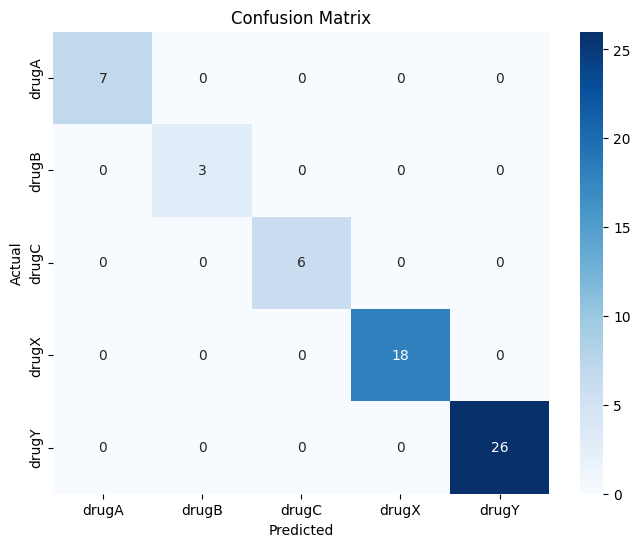

In [70]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=le_Drug.classes_, yticklabels=le_Drug.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Plot Feature Importance

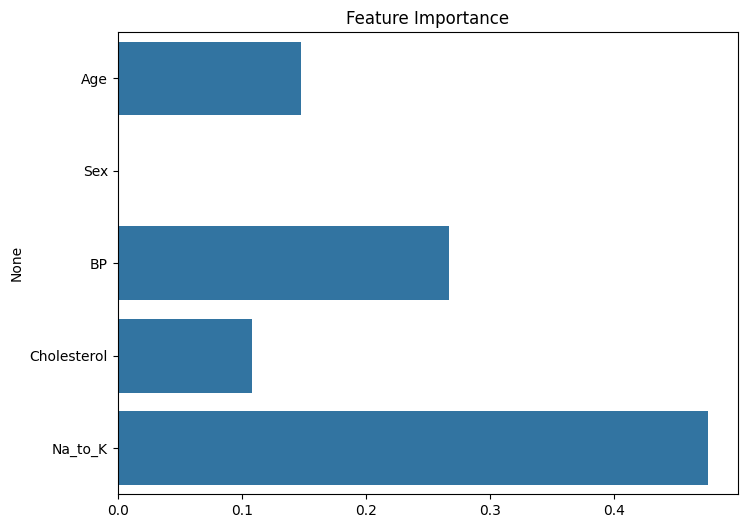

In [71]:
plt.figure(figsize=(8,6))
feature_importance = dt_model.feature_importances_
sns.barplot(x=feature_importance, y=X.columns)
plt.title('Feature Importance')
plt.show()

Print Classification Report

In [72]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le_Drug.classes_))

Classification Report:
              precision    recall  f1-score   support

       drugA       1.00      1.00      1.00         7
       drugB       1.00      1.00      1.00         3
       drugC       1.00      1.00      1.00         6
       drugX       1.00      1.00      1.00        18
       drugY       1.00      1.00      1.00        26

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



Decision Tree Visualization

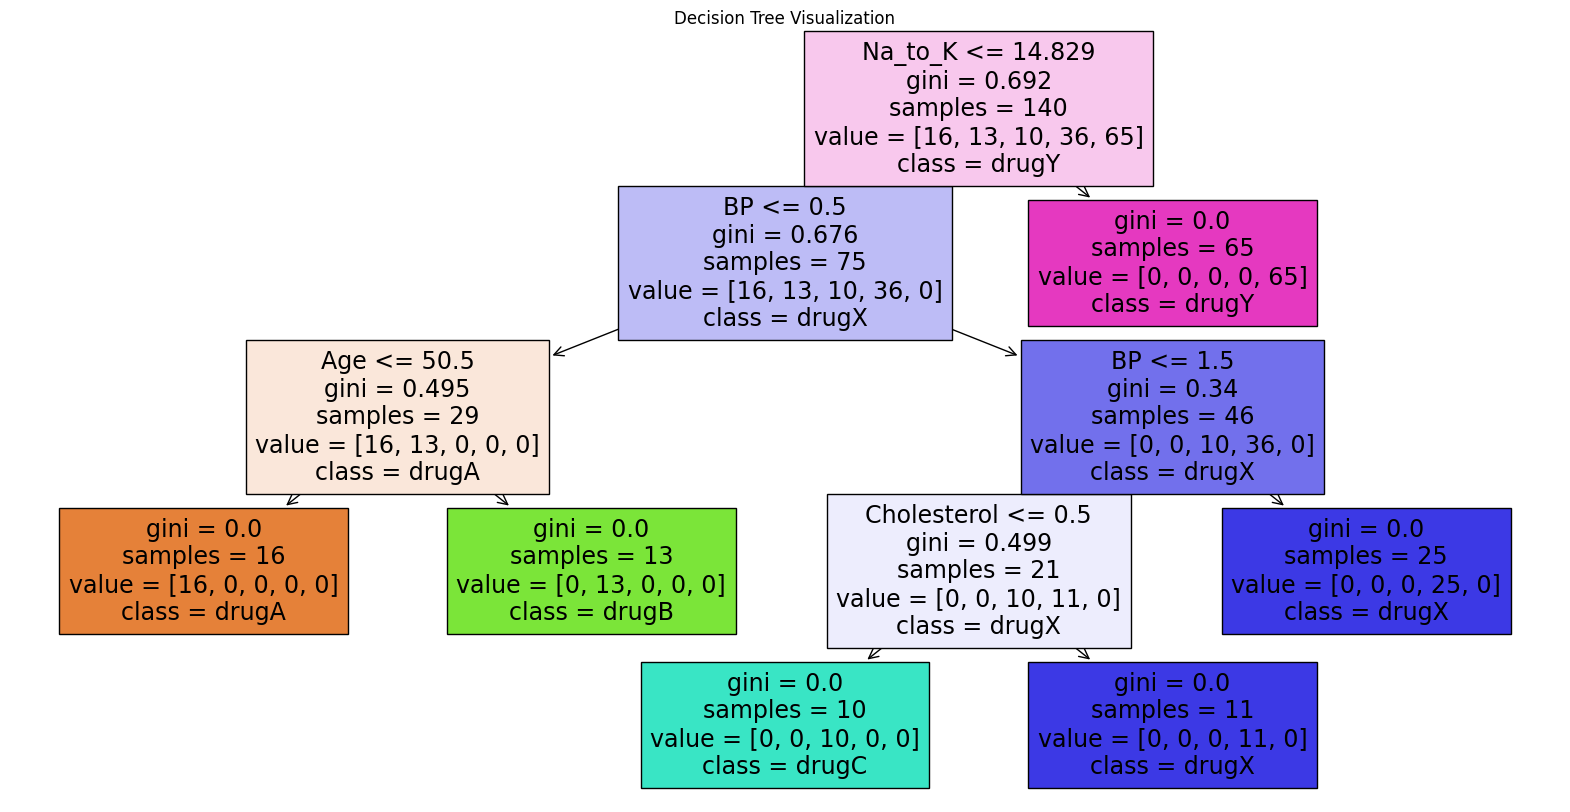

In [73]:
plt.figure(figsize=(20,10))
tree.plot_tree(dt_model, feature_names=X.columns, class_names=le_Drug.classes_, filled=True)
plt.title('Decision Tree Visualization')
plt.show()

Partial Dependence Plots for 'Na_to_K' and 'Age'

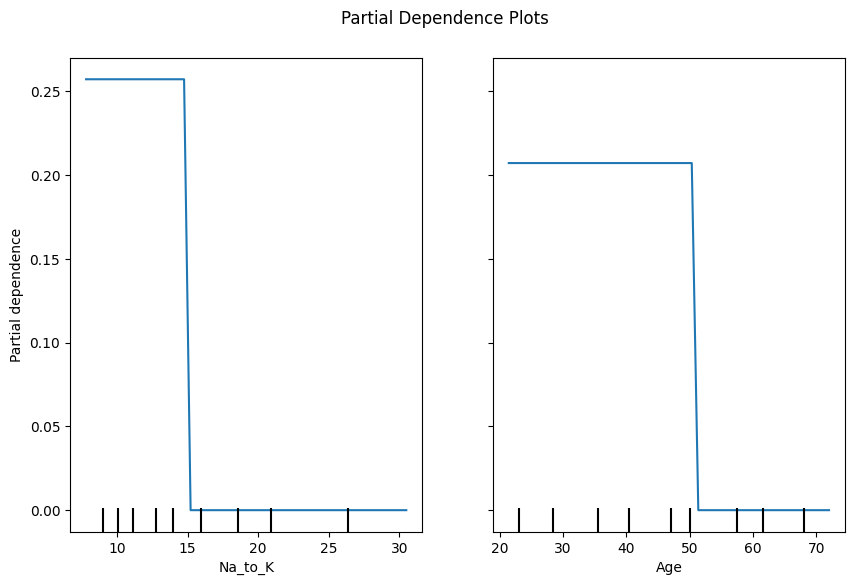

In [74]:
fig, ax = plt.subplots(figsize=(10, 6))
target_class = 0

display = PartialDependenceDisplay.from_estimator(
    dt_model,
    X_train,
    ['Na_to_K', 'Age'],
    grid_resolution=50,
    ax=ax,
    target=target_class
)

plt.suptitle('Partial Dependence Plots')
plt.subplots_adjust(top=0.9)
plt.show()

SHAP Values

In [75]:
explainer = shap.TreeExplainer(dt_model)
shap_values = explainer.shap_values(X_test)

Plot SHAP summary plot

<Figure size 1000x600 with 0 Axes>

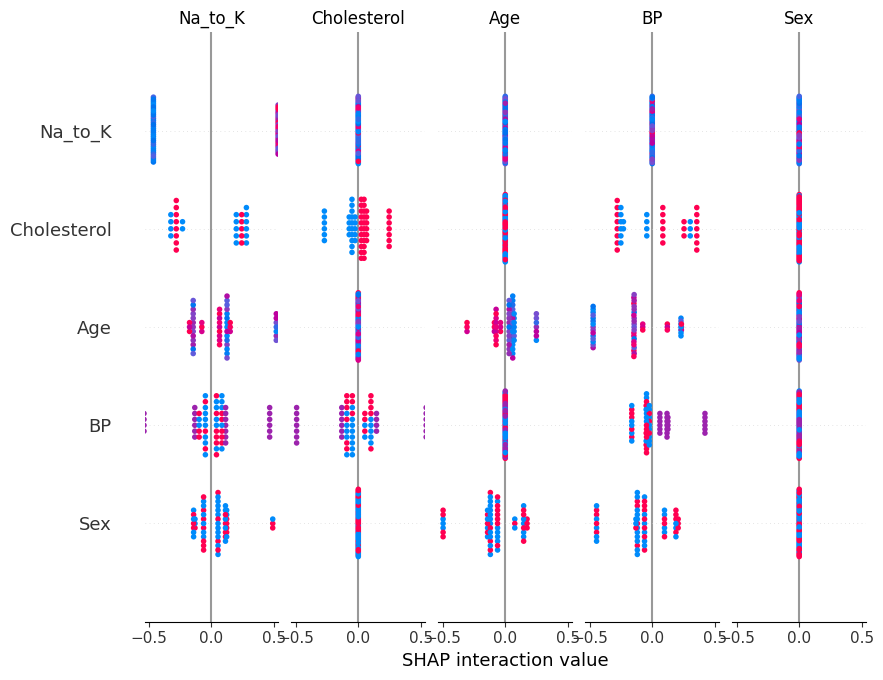

In [76]:
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

LIME Explanation for a single instance

In [77]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                       feature_names=X.columns,
                                                       class_names=le_Drug.classes_,
                                                       mode='classification')

i = 1

 Choose any instance from X_test

In [82]:
exp = lime_explainer.explain_instance(
    X_test.iloc[i].values,
    lambda x: dt_model.predict_proba(pd.DataFrame(x, columns=X_train.columns))
)
exp.show_in_notebook(show_table=True)
#shows output in google colab(notebooks compactable softwares)

Cross-Validation for Stability

In [79]:
cv_scores = cross_val_score(dt_model, X, y, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Average CV Score: {cv_scores.mean()}")

Cross-Validation Scores: [1.    1.    1.    0.925 1.   ]
Average CV Score: 0.985


Test case for prediction

In [80]:
test_case = pd.DataFrame({
    'Age': [30],
    'Sex': [le_sex.transform(['F'])[0]],
    'BP': [le_BP.transform(['HIGH'])[0]],
    'Cholesterol': [le_Chol.transform(['NORMAL'])[0]],
    'Na_to_K': [15.5]
})

Prediction for the test case

In [81]:
predicted_drug = dt_model.predict(test_case)
print(f'Test Case Prediction: {le_Drug.inverse_transform(predicted_drug)[0]}')

Test Case Prediction: drugY
